In [60]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.data import Data
from torch_geometric.nn import ARGA, GCNConv, ARGVA
from tqdm import trange
from utils import evaluate_clustering, get_clusters, plot_training_history, plot_3d_clustering_comparison

# Adversarially Regularized Graph Autoencoder
From the paper [Adversarially Regularized Graph Autoencoder for Graph Embedding](https://arxiv.org/pdf/1802.04407).

## Loading the data
We use the Cora dataset, a standard benchmark dataset for clustering.

In [61]:
dataset = Planetoid(root='../data/Planetoid', name='Cora')
data = dataset[0]
data.train_mask = data.test_mask = data.val_mask = None
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708])

## Encoder and discriminator models
We define a simple encoder with two GCN layers for the Adversarially Regularized Graph Autoencoder. The ARGA model only uses a latent vector $z$, while the ARGVA model uses distribution parameters $\mu$ and $\log{\sigma^2}$.
The discriminator is simply a fully connected neural network with three layers.

In [62]:
class GCNEncoder(nn.Module):
	def __init__(self, in_channels, latent_dim):
		super(GCNEncoder, self).__init__()
		self.conv1 = GCNConv(in_channels, 2 * latent_dim)
		self.conv2 = GCNConv(2 * latent_dim, latent_dim)

	def forward(self, x, edge_index):
		x = F.relu(self.conv1(x, edge_index))
		return self.conv2(x, edge_index)

In [63]:
class VGCNEncoder(nn.Module):
	def __init__(self, in_channels, latent_dim):
		super(VGCNEncoder, self).__init__()
		self.conv1 = GCNConv(in_channels, 2 * latent_dim)
		self.conv_mu = GCNConv(2 * latent_dim, latent_dim)
		self.conv_logstd = GCNConv(2 * latent_dim, latent_dim)

	def forward(self, x, edge_index):
		x = F.relu(self.conv1(x, edge_index))
		return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

In [64]:
class Discriminator(nn.Module):
	def __init__(self, latent_dim):
		super(Discriminator, self).__init__()
		self.fc1 = nn.Linear(latent_dim, latent_dim)
		self.fc2 = nn.Linear(latent_dim, latent_dim)
		self.fc3 = nn.Linear(latent_dim, 1)

	def forward(self, z):
		z = F.relu(self.fc1(z))
		z = F.relu(self.fc2(z))
		return torch.sigmoid(self.fc3(z))

## Instantiating and training the models
The ARGA and ARGVA models are instantiated and trained with their built-in loss function, which uses the reconstruction loss, the regularization loss, and the KL divergence in the VGAE. The discriminator also has a built-in loss function.

In [65]:
def train_model(model: ARGA | ARGVA, data: Data, optimizer: optim.Optimizer, discriminator_optimizer: optim.Optimizer, num_epochs: int = 200, k: int = 5, tqdm_desc: str = "Epochs") -> np.ndarray:
	metrics = np.zeros((num_epochs, 5))
	for epoch in (pbar := trange(num_epochs, desc=tqdm_desc)):
		optimizer.zero_grad()
		z = model.encode(data.x, data.edge_index)
		for i in range(k):
			discriminator_optimizer.zero_grad()
			discriminator_loss = model.discriminator_loss(z)
			discriminator_loss.backward()
			discriminator_optimizer.step()

		loss = model.recon_loss(z, data.edge_index) + model.reg_loss(z)
		if isinstance(model, ARGVA):
				loss += (1 / data.num_nodes) * model.kl_loss()
		loss.backward()
		optimizer.step()
		
		z_np = z.detach().numpy()
		accuracy, nmi, ari, silouhette = evaluate_clustering(z_np, data.y, get_clusters(z_np, n_clusters))
		metrics[epoch] = np.array([loss.item(), accuracy, nmi, ari, silouhette])
		pbar.set_postfix({"Loss": loss.item(), "Accuracy": accuracy, "NMI": nmi, "ARI": ari, "Silouhette": silouhette})
	return metrics

In [66]:
latent_dim, num_epochs, discriminator_lr, lr, n_clusters = 16, 100, .01, .005, len(np.unique(data.y.numpy()))

arga_discriminator = Discriminator(latent_dim)
arga = ARGA(GCNEncoder(data.num_features, latent_dim), arga_discriminator)
arga_discriminator_optimizer = optim.Adam(arga_discriminator.parameters(), lr=lr)
arga_optimizer = optim.Adam(arga.parameters(), lr=discriminator_lr)

argva_discriminator = Discriminator(latent_dim)
argva = ARGVA(VGCNEncoder(data.num_features, latent_dim), argva_discriminator)
argva_discriminator_optimizer = optim.Adam(argva_discriminator.parameters(), lr=lr)
argva_optimizer = optim.Adam(argva.parameters(), lr=discriminator_lr)

In [67]:
arga_training = train_model(arga, data, arga_optimizer, arga_discriminator_optimizer, num_epochs, tqdm_desc="ARGA")
argva_training = train_model(argva, data, argva_optimizer, argva_discriminator_optimizer, num_epochs, tqdm_desc="ARGVA")
history_labels = ['Loss', 'Accuracy', 'NMI Score', 'ARI Score', 'Silouhette Score']

ARGVA: 100%|██████████| 100/100 [00:37<00:00,  2.64it/s, Loss=1.56, Accuracy=0.683, NMI=0.486, ARI=0.439, Silouhette=0.212]     


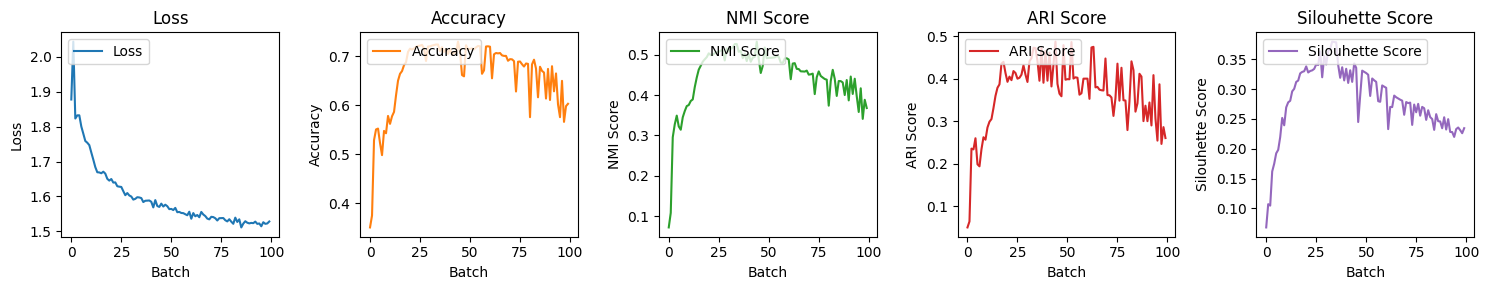

In [68]:
plot_training_history(history_labels, arga_training, "ARGA")

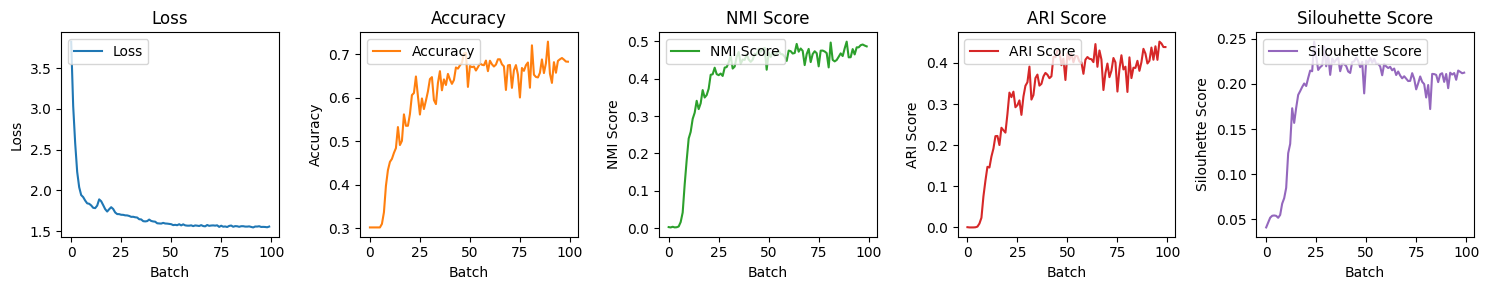

In [69]:
plot_training_history(history_labels, argva_training, "ARGVA")

In [70]:
arga_z, argva_z = arga.encode(data.x, data.edge_index).detach().numpy(), argva.encode(data.x, data.edge_index).detach().numpy()
arga_clusters, argva_clusters = get_clusters(arga_z, n_clusters), get_clusters(argva_z, n_clusters)

arga_accuracy, arga_nmi, arga_ari, arga_silouhette = evaluate_clustering(arga_z, data.y, arga_clusters)
argva_accuracy, argva_nmi, argva_ari, argva_silouhette = evaluate_clustering(argva_z, data.y, argva_clusters)

print(f"GAE Accuracy: {arga_accuracy:.4f}, NMI: {arga_nmi:.4f}, ARI: {arga_ari:.4f}, Silouhette: {arga_silouhette:.4f}")
print(f"VGAE Accuracy: {argva_accuracy:.4f}, NMI: {argva_nmi:.4f}, ARI: {argva_ari:.4f}, Silouhette: {argva_silouhette:.4f}")

GAE Accuracy: 0.6241, NMI: 0.3849, ARI: 0.2886, Silouhette: 0.2333
VGAE Accuracy: 0.6359, NMI: 0.4472, ARI: 0.3699, Silouhette: 0.1740


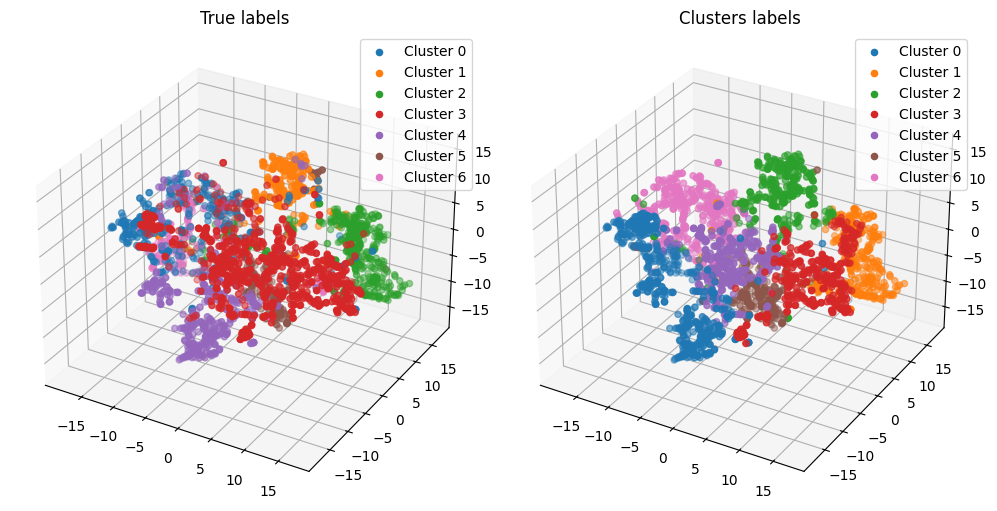

In [71]:
plot_3d_clustering_comparison(arga_z, data.y, arga_clusters, n_clusters)

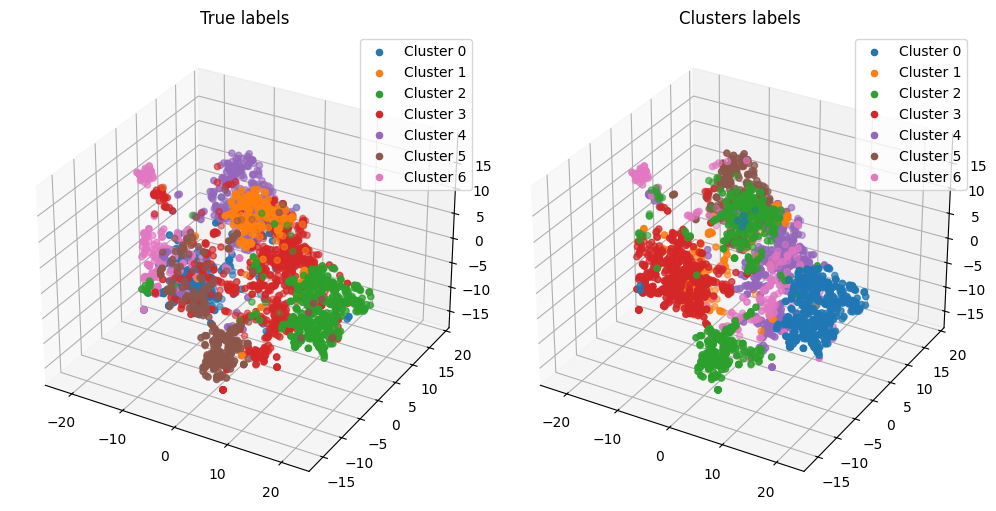

In [72]:
plot_3d_clustering_comparison(argva_z, data.y, argva_clusters, n_clusters)